# Workbook on Biomedical Imaging extraction
This workbook will have you practice some of the methods that we introduced in the demonstration notebook. For each step, you will find instructions for what to do followed by an empty code cell to enter your work. Don't forget that you will need to import the appropriate packages for this work.

The demonstration notebook showed you how to do a lot of these tasks within Python. However, if you would like to try out different command lines or include screenshots from your viewer, then we can show you how to include those into your answer.

In [1]:
import os
import nibabel as nb
import numpy as np
from niwidgets import NiftiWidget
import pandas as pd
import ants

## Step 1 - Load an MRI image
Please download the ADNI data from the Teams Channel. In the demonstration notebook we used subject `011-S-4906`. For this team workbook, please use subject `014-S-4263`. There are other subjects if you want to explore these methods on more data. Load in the raw image data and obtain the following information about the image.
* The number of slices
* The distance and time units used in this image
* The dimensions of each voxel
* The minimum and maximum intensity range
* The intensity value at the 50th column, 75th row, and 80th slice - **remember what number Python starts counting with.
* The Voxel-to-World mapping

In [39]:
# Your answer to Step 1
# Below put your code that will load up the image and prodcued the requested information


# Set data path
#data_root="/mnt/c/Users/adamr/Documents/GitHub/TeamCoders_Event_Based_Model/bids"
data_root="/groups/adamraikes/git_repos/TeamCoders_Event_Based_Model"
t1_img_name = os.path.join(data_root, "bids", "sub-014-S-4263","anat",
                            "sub-014-S-4263_desc-t1.nii.gz")


# Load subject 014-S-4263 T1w image and get the data for it
t1_img = nb.load(t1_img_name)
t1_img_data = t1_img.get_fdata()

# Print dimensions, number of slices, spacing, and voxel size
print(f"Dimensons: {t1_img.shape}")
print(f"Number of slices: {t1_img.shape[2]}")
print(f"Distance and Time Units: {t1_img.header.get_xyzt_units()}")
print(f"Voxel spacing (in mm): {t1_img.header.get_zooms()}")
print()

# Print min and max values
img_min = t1_img_data.min()
img_max = t1_img_data.max()
print(f"Minimum voxel intensity: {img_min}")
print(f"Maximum voxel intensity: {img_max}")
print()

# Print intensity i = 50, j = 75, k = 80
test_voxel = (49,74,79)
print(f"Intensity at voxel {t1_img_data[test_voxel]}")
print()

# Print affine mapping
print("T1 image affine (voxel to world):")
print(t1_img.affine)

Dimensons: (176, 240, 256)
Number of slices: 256
Distance and Time Units: ('mm', 'sec')
Voxel spacing (in mm): (1.1999999, 1.0546875, 1.0546875)

Minimum voxel intensity: 0.0
Maximum voxel intensity: 1000.0

Intensity at voxel 182.0

T1 image affine (voxel to world):
[[   1.20000458    0.            0.         -105.00079346]
 [   0.            1.0546875     0.          -86.45697021]
 [   0.            0.            1.0546875  -157.8097229 ]
 [   0.            0.            0.            1.        ]]


## Step 2 - Bias Correction
Perform bias correction on the brain image and plot the corrected image and the difference between the original and corrected image. Try the N4 algorithm as well as the N3 and let me know what differences (if any) that you find

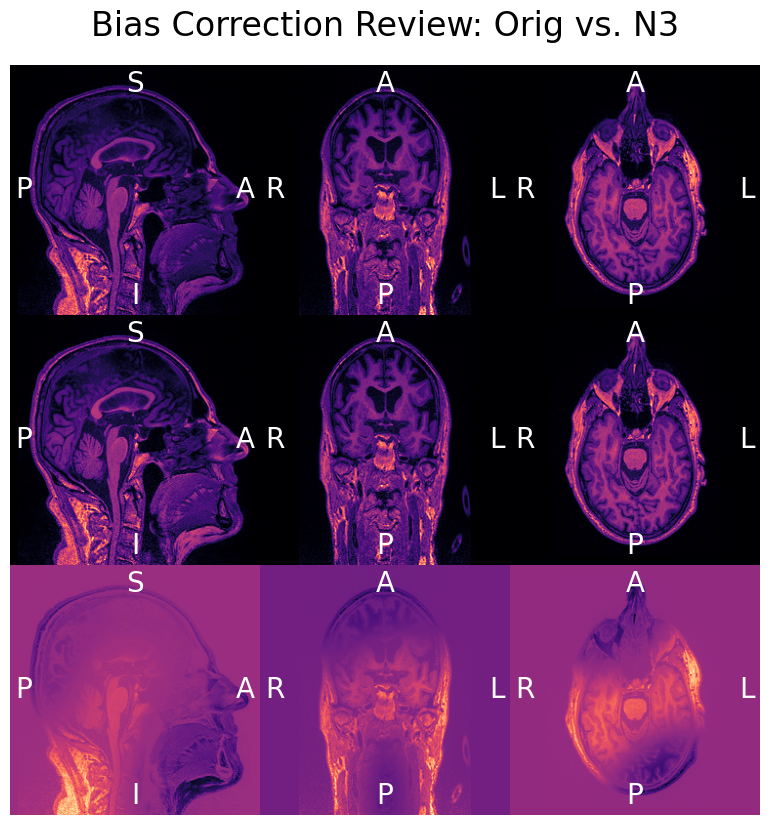

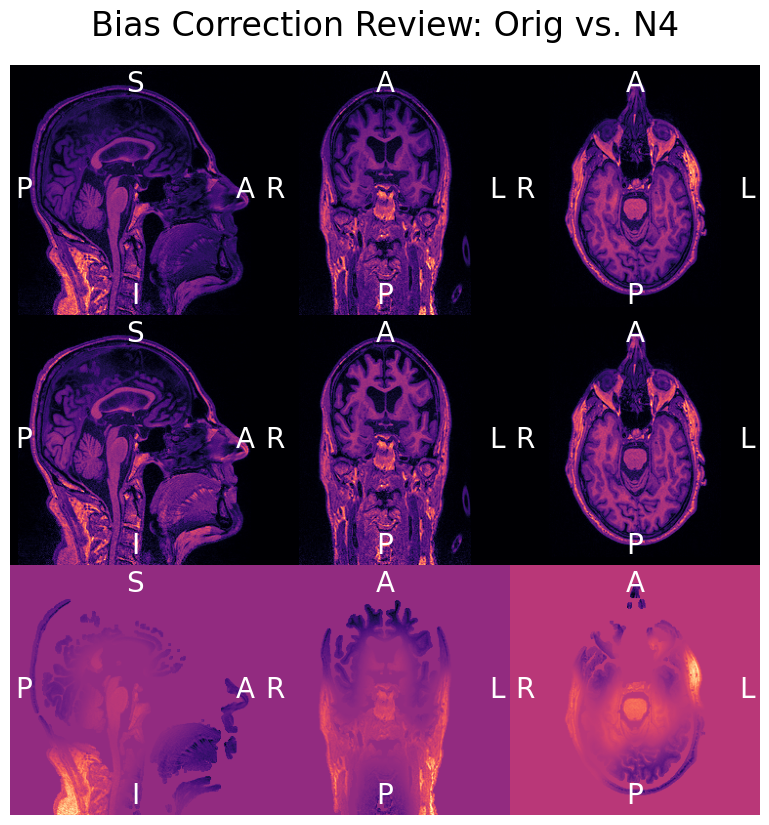

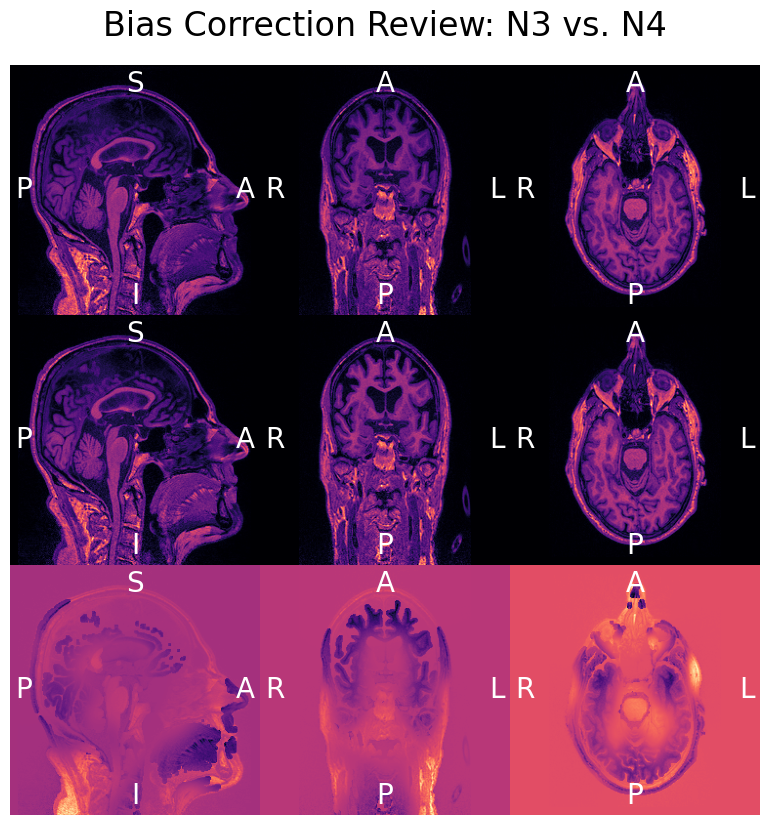

In [6]:
# Your answers to Step 2
# Load in the image
t1_img = ants.image_read(t1_img_name)

#Peform the N3 bias correcction. No options to set.
t1_n3 = ants.n3_bias_field_correction(t1_img)

# Run N4 bias correction. Use defaults
t1_n4 = ants.n4_bias_field_correction(t1_img)

# Compute differences between original image and N3/N4 corrected images as well as N3 vs. N4.
t1_n3_diff = t1_img - t1_n3
t1_n4_diff = t1_img - t1_n4
n3_n4_diff = t1_n3 - t1_n4

ants.plot_ortho_stack(images = [t1_img,t1_n3,t1_n3_diff],
                      title="Bias Correction Review: Orig vs. N3",
                     cmap = "magma")

ants.plot_ortho_stack(images = [t1_img,t1_n4,t1_n4_diff],
                      title="Bias Correction Review: Orig vs. N4",
                     cmap = "magma")

ants.plot_ortho_stack(images = [t1_n3, t1_n4, n3_n4_diff],
                      title="Bias Correction Review: N3 vs. N4",
                     cmap = "magma")

# N3 bias correction provides stronger bias correction below the ventricles. N4 bias correction ignores
# more of the bias field associated with the superior dura and skull. Both show that the bias field was 
# oriented on a diagonal from right-posterior to left-anterior.

## Step 3 - Brain extraction
Produce a skull-stripped image from the bias corrected image. Make sure to do additional cleaning if you think it is necessary. What is the volume of the resulting mask?

 bad det -1 v 1 u -1
 bad det -1 v 1 u -1 new 1


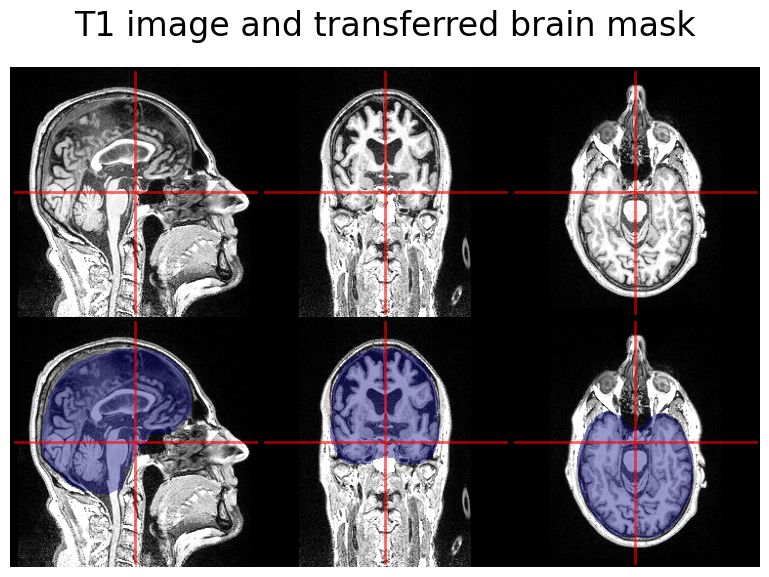

In [7]:
# Your answer to Step 3

# Set atlas path
atlasdir = os.path.join(data_root,"atlas")

# Load MNI image
mni_img_file = os.path.join(atlasdir,"MNI152_T1_1mm.nii.gz")
mni_img = ants.image_read(mni_img_file)

# Load MNI mask
mni_mask_file = os.path.join(atlasdir,"MNI152_T1_1mm_brain_mask_dil.nii.gz")
mni_mask = ants.image_read(mni_mask_file)

# Find initial guess for masking of the N4 file
init_tx_file = ants.affine_initializer(fixed_image = mni_img, moving_image = t1_n4, mask = mni_mask)
init_tx = ants.read_transform(init_tx_file)

# Transform T1 with initial guess
t1_mni_init = ants.apply_transforms(fixed = mni_img, moving = t1_n4,transformlist=init_tx_file)

affine = ants.registration(fixed = mni_img, moving = t1_n4,
                           mask = mni_mask,
                           type_of_transform = "Affine", 
                           initial_transform = init_tx_file)

# Inverse warp the mask to native space.
t1_mask = ants.apply_transforms(fixed = t1_n4, moving = mni_mask, interpolator="nearestNeighbor",
                                transformlist=affine['fwdtransforms'],whichtoinvert=[True])

# Plot image
ants.plot_ortho_double(image=t1_n4, image2=t1_n4, scale=True, scale2=True, 
                       overlay=t1_mask, overlay2=t1_mask,
                       overlay_alpha=0.0, overlay_alpha2=0.4,
                       title="T1 image and transferred brain mask",title_dy=0.25)

# Some dura remains.

# Mask cleanup

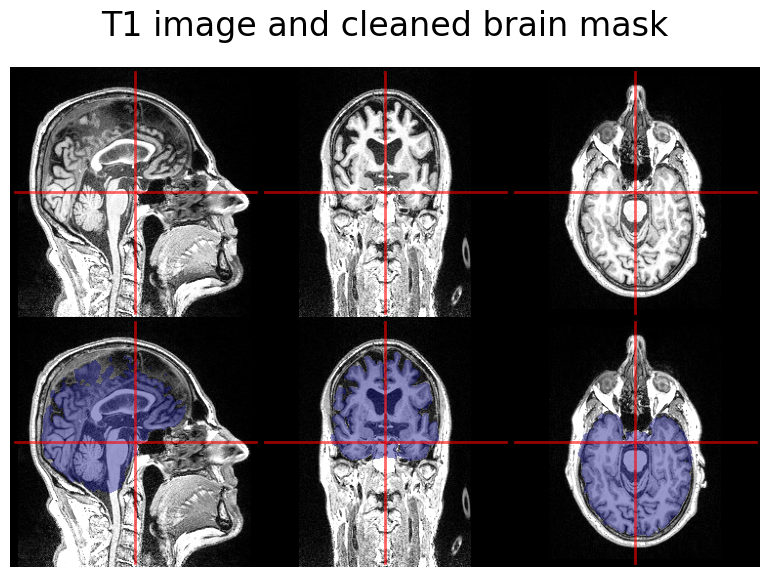

In [8]:
# The utility get_mask can clean up the additional bits outside the brain
t1_brain = ants.mask_image(t1_n4,t1_mask)
t1_mask_cleaned = ants.get_mask(t1_brain,cleanup=3)
t1_brain_cleaned = ants.mask_image(t1_n4,t1_mask_cleaned)

ants.plot_ortho_double(image=t1_n4, image2=t1_n3, scale=True, scale2=True, 
                       overlay=t1_mask_cleaned, overlay2=t1_mask_cleaned,
                       overlay_alpha=0.0, overlay_alpha2=0.4,
                       title="T1 image and cleaned brain mask",title_dy=0.25)

# Get brain mask volume

In [12]:
tissue_stats = ants.label_stats(t1_n4,t1_mask_cleaned)
mask_vol = tissue_stats.Volume[1]
print(f"Mask volume: {mask_vol} mm^3")

Mask volume: 12859778.0 mm^3


## Step 4 - Tissue segmentation
Perform tissue segmentation on the image. Is the GM volume in this subject more or less than the subject `011-S-4906`? Is it a greater or less percentage of the overall brain?

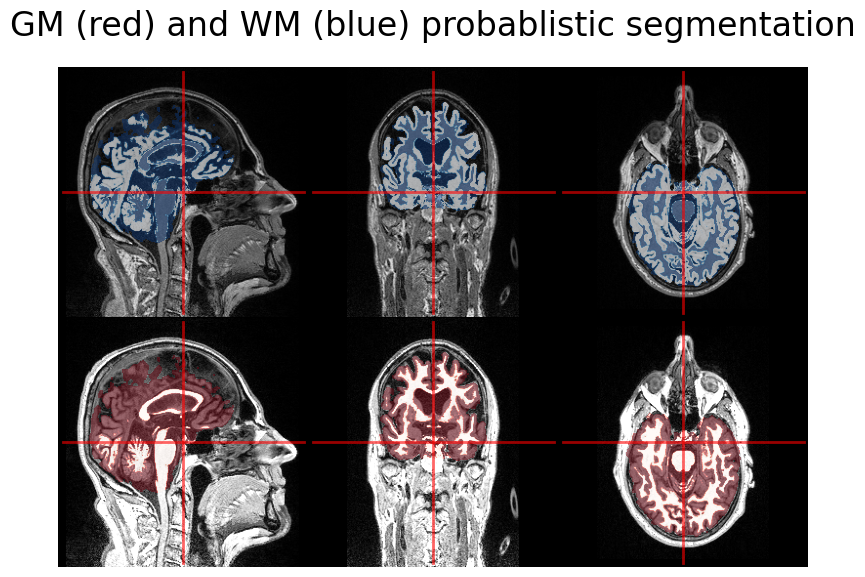

   LabelValue        Mean         Min         Max      Variance      Count  \
3         0.0   58.455023    0.000000  851.000000  10103.443020  9633956.0   
0         1.0   75.959629    0.000000  180.000000    948.477724   292894.0   
1         2.0  191.900591   90.068382  569.656067    949.134625   528335.0   
2         3.0  279.494505  194.422302  646.522095    629.525730   358255.0   

         Volume          Mass         x          y         z    t  
3  1.285978e+07  0.000000e+00  0.000000   0.000000  0.000000  0.0  
0  3.909662e+05  2.224812e+07 -1.477119 -12.137896  0.483357  0.0  
1  7.052420e+05  1.013878e+08  0.910855  -9.109062 -3.312238  0.0  
2  4.782127e+05  1.001303e+08  0.160961 -12.078033  5.081498  0.0  


In [30]:
# Your answer to Step 4

# Run Atropos with default parameters and Kmeans clustering
#tissue_seg = ants.atropos(a=t1_n4,x=t1_mask_cleaned,m="[0.3,1x1x1]", i='Kmeans[3]')

# Tissue segmentation order: CSF, GM, WM. Plotting uses reverse coloring (via Dave). Not clear why a direct
# color mapping wasn't used (e.g., Reds for seg[1])
ants.plot_ortho_double(image = t1_n4,image2=t1_n4,
                       overlay=tissue_seg['probabilityimages'][1], overlay_alpha=0.5, overlay_cmap='Blues_r',
                       overlay2=tissue_seg['probabilityimages'][2], overlay_alpha2=0.5,overlay_cmap2='Reds_r',
                       title="GM (red) and WM (blue) probablistic segmentation",title_dy=0.25)

# Print tissue segmentation statistics.
# Remember that Label == 0 is background and is ignored when accessing statistics
# Label == 1 : CSF
# Label == 2 : GM
# Label == 3 : WM
tissue_stats = ants.label_stats(t1_n4,tissue_seg['segmentation'])
print(tissue_stats)

In [28]:
## Compare GM segmentation with 011-S-4906
gm_vol_011 =  478405 * (1.1999999*1*1)
tiv_011 = gm_vol_011 + 350432 * (1.1999999*1*1) + 398100 * (1.1999999*1*1)
gm_perc_011 = gm_vol_011/tiv_011 * 100

gm_vol_014 = tissue_stats.Volume[1]
tiv_014 = tissue_stats.Volume[0] + tissue_stats.Volume[1] + tissue_stats.Volume[2]
gm_perc_014 = gm_vol_014/tiv_014 * 100

print(f"Subject 014 GM: {gm_vol_011}")
print(f"Subject 011 GM as percent of TIV: {gm_perc_011}")
print(f"Subject 014 GM: {gm_vol_014}")
print(f"Subject 014 GM as percent of TIV: {gm_perc_014}")

# Subject 014 has both a greater absolute amount of GM as well as relative

Subject 014 GM: 574085.9521595
Subject 011 GM as percent of TIV: 38.99181457564651
Subject 014 GM: 705242.0
Subject 014 GM as percent of TIV: 44.79373953943264


## Step 5 - Brain parcellation
One of you should run FreeSurfer on this subject. You should also transfer the AAL labels to this subject. Tell me what the volumes of the left and right precuneus are for both methods.

### AAL registration

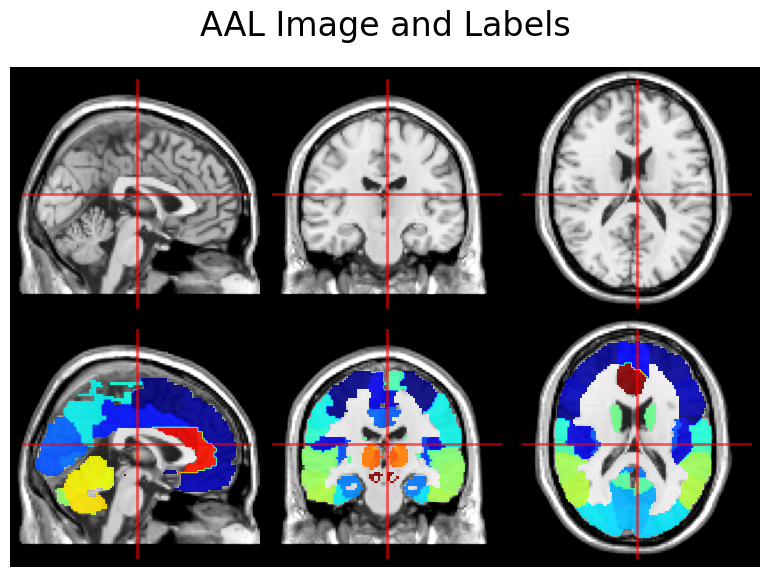

In [31]:
# Your answer to Step 5
# Determine template, rigid + SYN and then transfer labels over. 
aal_template_file = os.path.join(atlasdir,"AAL3v1_1mm.nii.gz")
aal_template = ants.image_read(aal_template_file).astype("uint32")
aal_img_file = os.path.join(atlasdir,"single_subj_T1.nii")
aal_img = ants.image_read(aal_img_file)
ants.plot_ortho_double(image=aal_img,image2=aal_img, scale=True,scale2=True,overlay=aal_template,overlay2=aal_template,
                      overlay_alpha=0.0,title="AAL Image and Labels",title_dy=0.25)

 bad det -1 v 1 u -1
 bad det -1 v 1 u -1 new 1


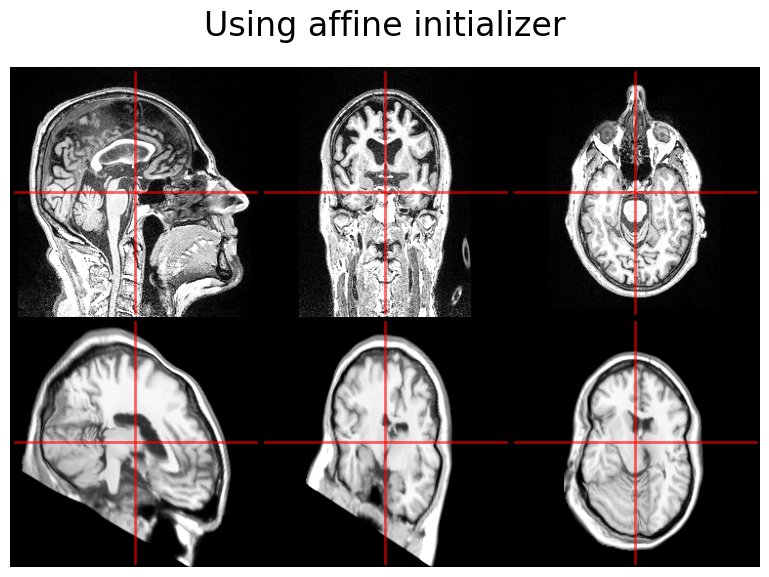

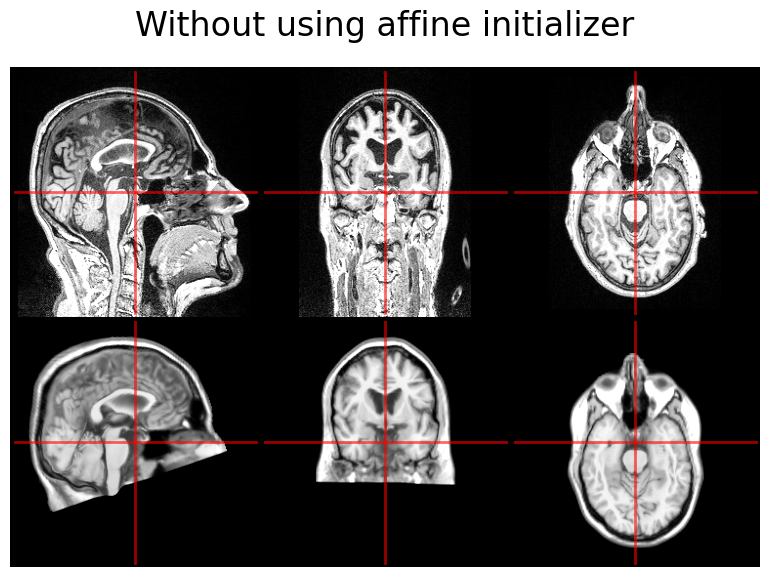

In [35]:
# Do an affine initialisation between N4 bias corrected image and AAL template image.
t1_mask_dil = ants.iMath(t1_mask_cleaned,'MD',2)
aal_affine_init_file = ants.affine_initializer(fixed_image = t1_n4,moving_image = aal_img)

# Perform deformable registration using SyN and MI
syn_aal_bad = ants.registration(fixed=t1_n4,
                            moving=aal_img,
                            mask=t1_mask_dil,
                            initial_transform=aal_affine_init_file,
                            type_of_transform="SyN",
                            reg_iterations=(60,30,15))


# Affine initializer was removed because it generated poorer performing registration.
syn_aal = ants.registration(fixed=t1_n4,
                            moving=aal_img,
                            mask=t1_mask_dil,
                            type_of_transform="SyN",
                            reg_iterations=(60,30,15))

ants.plot_ortho_double(image=t1_n4, image2=syn_aal_bad['warpedmovout'], scale=True,scale2=True,
                       title="Using affine initializer",title_dy=0.25)

ants.plot_ortho_double(image=t1_n4, image2=syn_aal['warpedmovout'], scale=True,scale2=True,
                       title="Without using affine initializer",title_dy=0.25)


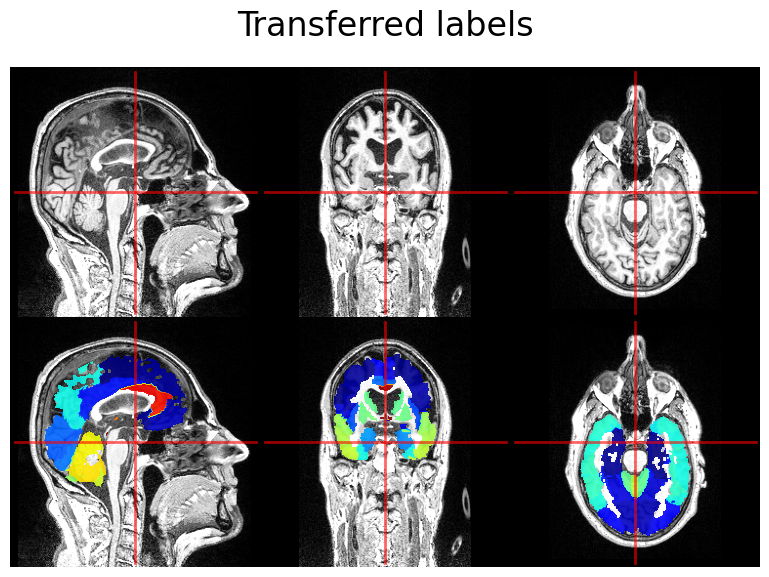

In [36]:
# Transfer anatomical labels from AAL to our image
t1_aal_label = ants.apply_transforms(fixed = t1_n4, moving = aal_template,
                                     transformlist=syn_aal['fwdtransforms'],interpolator="genericLabel")

ants.plot_ortho_double(image=t1_n4,image2=t1_n4,overlay=t1_aal_label,overlay2=t1_aal_label,
                       scale=True,scale2=True,
                      overlay_alpha=0.0,title="Transferred labels",title_dy=0.25)

### AAL Stats

In [52]:
# Get statistics
aal_stats = ants.label_stats(t1_n4,t1_aal_label)
# Grab label names
df_aal = pd.read_table(os.path.join(atlasdir,"AAL3v1_1mm.nii.txt"),
names=["LabelName","LabelValue"],delim_whitespace=True)
df_aal = df_aal.set_index("LabelValue")
aal_stats = aal_stats.set_index("LabelValue")
aal_stats = aal_stats.join(df_aal)
aal_stats = aal_stats.set_index("LabelName")
aal_stats = aal_stats[["Volume","Mean","Min","Max","Variance"]]
print(aal_stats)

# Precuneus volumes
lprec = aal_stats.filter(items = ['Precuneus_L'], axis = 0)
rprec = aal_stats.filter(items = ['Precuneus_R'], axis = 0)

print()
print()
print(f"Left precuneus volume: {lprec.Volume[0]} mm^3")
print(f"Right precuneus volume: {rprec.Volume[0]} mm^3")

                       Volume        Mean         Min         Max  \
LabelName                                                           
NaN              1.316648e+07   62.416190    0.000000  851.000000   
Precentral_L     1.940855e+04  187.501449    0.000000  337.050720   
Precentral_R     2.326490e+04  188.685067    1.000000  340.088470   
Frontal_Sup_2_L  2.766320e+04  174.960886    0.000000  359.102631   
Frontal_Sup_2_R  3.112577e+04  174.953413    0.000000  363.642731   
...                       ...         ...         ...         ...   
Red_N_R          5.366052e+02  279.712572  210.096817  329.204681   
LC_L             9.343871e+00  237.530777  168.265381  312.309509   
LC_R             1.334839e+01  167.122762  106.068558  208.433868   
Raphe_D          7.742065e+01  212.795225   74.236504  275.696472   
Raphe_M          2.803161e+01  221.836633   86.008003  306.415100   

                     Variance  
LabelName                      
NaN              10666.802338  
Precen

### Freesurfer

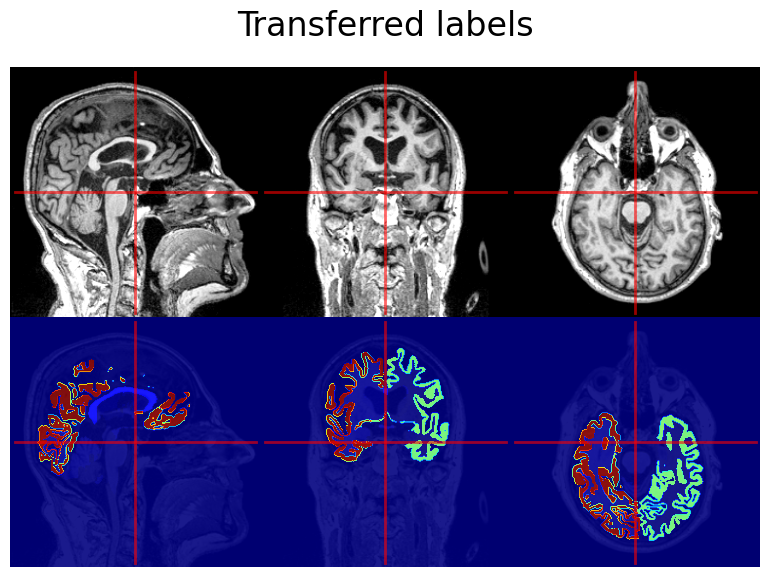

In [45]:
# Load N4 corrected image from Freesurfer
t1_fs_nu_filename = os.path.join(data_root, "derivatives", "freesurfer", "sub-014-S-4263",
                                "mri", "nu.mgz")
t1_fs_nu = ants.image_read(t1_fs_nu_filename)

# Load APARC atlas file
dk_atlas = ants.image_read(os.path.join(data_root, "derivatives", "freesurfer", "sub-014-S-4263",
                                        "mri", "aparc+aseg.mgz")).astype('uint32')

ants.plot_ortho_double(image=t1_fs_nu,image2=t1_fs_nu,overlay=dk_atlas,overlay2=dk_atlas,
                       scale=True,scale2=True,
                      overlay_alpha=0.0,title="Transferred labels",title_dy=0.25)


## Step 6 - PET SUVR measurements
Finally, register the PET data with the MRI and give SUVR precuneus measures from both parcellations above using the cerebellum region as the reference. Is this person have higher or lower uptake than subject `011-S-4906`? What would the SUVR be if the reference region was the pons?

In [ ]:
# Your answer to Step 6
# Creating a brain mask and extracting volumes out